In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import cv2

/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [3]:
tqdm.pandas()

# Data set

This data source is downloaded from https://github.com/joojs/fairface

in the within the scope of the research "FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age"

In [4]:
train_df = pd.read_csv("fairface_label_train.csv")
test_df = pd.read_csv("fairface_label_val.csv")

In [5]:
print("trainset consists of ",train_df.shape)
print("test set consist of ",test_df.shape)

trainset consists of  (86744, 5)
test set consist of  (10954, 5)


In [6]:
train_df = train_df[['file', 'race']]
test_df = test_df[['file', 'race']]

In [7]:
train_df['file'] = 'FairFace/'+train_df['file']
test_df['file'] = 'FairFace/'+test_df['file']

In [8]:
train_df.head()

file        race
0  FairFace/train/1.jpg  East Asian
1  FairFace/train/2.jpg      Indian
2  FairFace/train/3.jpg       Black
3  FairFace/train/4.jpg      Indian
4  FairFace/train/5.jpg      Indian

In [9]:
100*train_df.groupby(['race']).count()[['file']]/train_df.groupby(['race']).count()[['file']].sum()

file
race                      
Black            14.102416
East Asian       14.164668
Indian           14.201559
Latino_Hispanic  15.409711
Middle Eastern   10.624366
Southeast Asian  12.444665
White            19.052615

In [10]:
# There are 2 races as East and Southeast Asian. Group them in a single Asian Race
idx = train_df[(train_df['race'] == 'East Asian') | (train_df['race'] == 'Southeast Asian')].index
train_df.loc[idx, 'race'] = 'Asian'

idx = test_df[(test_df['race'] == 'East Asian') | (test_df['race'] == 'Southeast Asian')].index
test_df.loc[idx, 'race'] = 'Asian'

In [11]:
100*train_df.groupby(['race']).count()[['file']]/train_df.groupby(['race']).count()[['file']].sum()

file
race                      
Asian            26.609333
Black            14.102416
Indian           14.201559
Latino_Hispanic  15.409711
Middle Eastern   10.624366
White            19.052615

In [12]:
target_size = (224, 224)

def getImagePixels(file):
    #print(file)
    img = image.load_img(file, grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

In [13]:
train_df['pixels'] = train_df['file'].progress_apply(getImagePixels)
test_df['pixels'] = test_df['file'].progress_apply(getImagePixels)

100%|██████████| 10954/10954 [00:23<00:00, 466.53it/s]


In [14]:
train_df.head()

file    race  \
0  FairFace/train/1.jpg   Asian   
1  FairFace/train/2.jpg  Indian   
2  FairFace/train/3.jpg   Black   
3  FairFace/train/4.jpg  Indian   
4  FairFace/train/5.jpg  Indian   

                                              pixels  
0  [8.0, 8.0, 10.0, 9.0, 9.0, 11.0, 10.0, 8.0, 11...  
1  [129.0, 127.0, 104.0, 127.0, 125.0, 102.0, 123...  
2  [216.0, 171.0, 174.0, 212.0, 167.0, 170.0, 206...  
3  [42.0, 47.0, 50.0, 42.0, 47.0, 50.0, 41.0, 46....  
4  [44.0, 39.0, 35.0, 44.0, 39.0, 35.0, 43.0, 40....

In [15]:
train_features = []; test_features = []

for i in range(0, train_df.shape[0]):
    train_features.append(train_df['pixels'].values[i])

for i in range(0, test_df.shape[0]):
    test_features.append(test_df['pixels'].values[i])

In [16]:
tic = time.time()

train_features = np.array(train_features)
train_features = train_features.reshape(train_features.shape[0], 224, 224, 3)

test_features = np.array(test_features)
test_features = test_features.reshape(test_features.shape[0], 224, 224, 3)

toc = time.time()

print("converted to numpy in ",toc-tic,"seconds")

converted to numpy in  49.3110613822937 seconds


In [17]:
tic = time.time()

train_features = train_features / 255
test_features = test_features / 255

toc = time.time()

print("converted to numpy in ",toc-tic,"seconds")

converted to numpy in  24.123751163482666 seconds


In [18]:
train_label = train_df[['race']]
test_label = test_df[['race']]

In [19]:
races = train_df['race'].unique()

In [20]:
for j in range(len(races)): #label encoding
    current_race = races[j]
    print("replacing ",current_race," to ", j+1)
    train_label['race'] = train_label['race'].replace(current_race, str(j+1))
    test_label['race'] = test_label['race'].replace(current_race, str(j+1))

train_label = train_label.astype({'race': 'int32'})
test_label = test_label.astype({'race': 'int32'})

replacing  Asian  to  1


/opt/rh/rh-python36/root/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/rh/rh-python36/root/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


replacing  Indian  to  2
replacing  Black  to  3
replacing  White  to  4
replacing  Middle Eastern  to  5
replacing  Latino_Hispanic  to  6


In [21]:
train_label.head()

race
0     1
1     2
2     3
3     2
4     2

In [22]:
train_target = pd.get_dummies(train_label['race'], prefix='race')
test_target = pd.get_dummies(test_label['race'], prefix='race')

In [23]:
train_target.head()

race_1  race_2  race_3  race_4  race_5  race_6
0       1       0       0       0       0       0
1       0       1       0       0       0       0
2       0       0       1       0       0       0
3       0       1       0       0       0       0
4       0       1       0       0       0       0

## Validation set to avoid overfitting

In [24]:
train_x, val_x, train_y, val_y = train_test_split(train_features, train_target.values
                                        , test_size=0.12, random_state=17)

# Model

In [25]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

In [26]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [27]:
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('vgg_face_weights.h5')

In [28]:
num_of_classes = len(races)

In [29]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(num_of_classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

race_model = Model(inputs=model.input, outputs=base_model_output)

In [30]:
race_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  , metrics=['accuracy']
                 )

# Load pre-trained weights

You can skip training step and load pre-trained weights

In [ ]:
#race_model.load_weights('race_model_weights_full_v2.h5')

# Training

In [31]:
checkpointer = ModelCheckpoint(
    filepath='race_model_single_batch.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [32]:
patience = 50

In [33]:
val_scores = []; train_scores = []

In [34]:
enableBatch = True

epochs = 1000

if enableBatch != True:
    early_stop = EarlyStopping(monitor='val_loss', patience=patience) 
    
    score = race_model.fit(
        train_x, train_y
        , epochs=epochs
        , validation_data=(val_x, val_y)
        , callbacks=[checkpointer, early_stop]
    )
else:
    batch_size = pow(2, 14)
    last_improvement = 0
    best_iteration = 0
    
    loss = 1000000 #initialize as a large value
    
    for i in range(0, epochs):
        
        print("Epoch ", i, ". ", end='')
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = race_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(val_x, val_y)
            , callbacks=[checkpointer]
        )
        
        val_loss = score.history['val_loss'][0]
        train_loss = score.history['loss'][0]
        
        val_scores.append(val_loss)
        train_scores.append(train_loss)
        
        #--------------------------------
        
        if val_loss < loss:
            loss = val_loss * 1
            last_improvement = 0
            best_iteration = i * 1
        else:
            last_improvement = last_improvement + 1
            print("try to decrease val loss for ",patience - last_improvement," epochs more")
        
        #--------------------------------
        
        if last_improvement == patience:
            print("there is no loss decrease in validation for ",patience," epochs. early stopped")
            break

Epoch  0 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [==============================] - 83s 5ms/step - loss: 1.0934 - acc: 0.5884 - val_loss: 1.0354 - val_acc: 0.5942

Epoch 00001: val_loss improved from inf to 1.03541, saving model to race_model_single_batch.hdf5
Epoch  1 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [==============================] - 73s 4ms/step - loss: 1.0230 - acc: 0.6207 - val_loss: 0.9554 - val_acc: 0.6447

Epoch 00001: val_loss improved from 1.03541 to 0.95545, saving model to race_model_single_batch.hdf5
Epoch  2 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [==============================] - 74s 5ms/step - loss: 1.0199 - acc: 0.6259 - val_loss: 0.9502 - val_acc: 0.6476

Epoch 00001: val_loss improved from 0.95545 to 0.95023, saving model to race_model_single_batch.hdf5
Epoch  3 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [=======================

Epoch  55 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [==============================] - 74s 5ms/step - loss: 0.5711 - acc: 0.8044 - val_loss: 0.9359 - val_acc: 0.6837

Epoch 00001: val_loss did not improve from 0.88540
try to decrease val loss for  24  epochs more
Epoch  56 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [==============================] - 79s 5ms/step - loss: 0.5769 - acc: 0.8076 - val_loss: 0.9303 - val_acc: 0.6819

Epoch 00001: val_loss did not improve from 0.88540
try to decrease val loss for  23  epochs more
Epoch  57 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [==============================] - 89s 5ms/step - loss: 0.5533 - acc: 0.8118 - val_loss: 0.9615 - val_acc: 0.6815

Epoch 00001: val_loss did not improve from 0.88540
try to decrease val loss for  22  epochs more
Epoch  58 . Train on 16384 samples, validate on 10410 samples
Epoch 1/1
16384/16384 [===========================

# Plot loss

Loss over iterations. It might be overfitted.

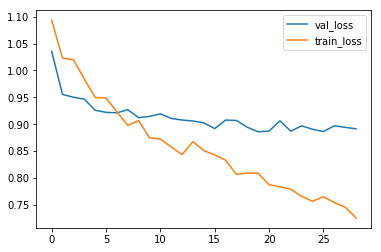

In [35]:
if enableBatch != True:
    plt.plot(score.history['val_loss'], label='val_loss')
    plt.plot(score.history['loss'], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()
else:
    plt.plot(val_scores[0:best_iteration], label='val_loss')
    plt.plot(train_scores[0:best_iteration], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()   

Loss until the best iteration

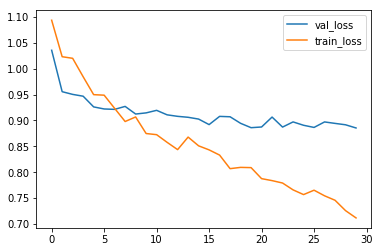

In [37]:
if enableBatch != True:
    plt.plot(score.history['val_loss'][0:best_iteration], label='val_loss')
    plt.plot(score.history['loss'][0:best_iteration], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()
else:
    plt.plot(val_scores[0:best_iteration+1], label='val_loss')
    plt.plot(train_scores[0:best_iteration+1], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()   

# Load the best model

In [38]:
#restore the best weights
from keras.models import load_model
race_model = load_model("race_model_single_batch.hdf5")

race_model.save_weights('race_model_single_batch.h5')

# Evaluation

In [39]:
test_perf = race_model.evaluate(test_features, test_target.values, verbose=1)
print(test_perf)

10954/10954 [==============================] - 29s 3ms/step
[0.8816864295817214, 0.6817600876174531]


In [40]:
validation_perf = race_model.evaluate(val_x, val_y, verbose=1)
print(validation_perf)

10410/10410 [==============================] - 26s 3ms/step
[0.8853952231256007, 0.6782901056561759]


In [41]:
#Check model is robust
abs(validation_perf[0] - test_perf[0]) < 0.01

True

# Prediction

In [42]:
predictions = race_model.predict(test_features)

17
Actual:  White
Predicted:  White


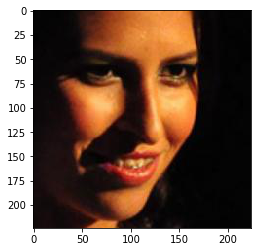

----------------------
33
Actual:  Asian
Predicted:  Asian


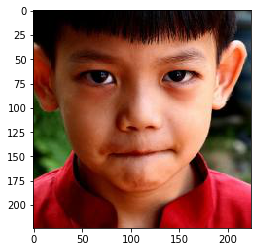

----------------------
83
Actual:  Asian
Predicted:  Asian


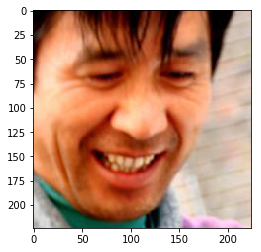

----------------------
109
Actual:  Indian
Predicted:  Indian


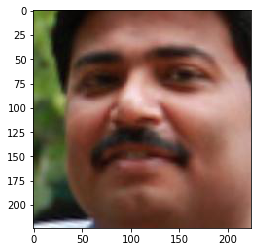

----------------------
124
Actual:  Black
Predicted:  Black


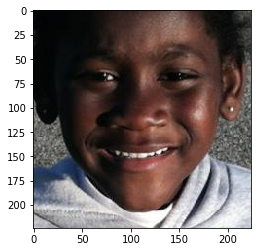

----------------------
203
Actual:  Indian
Predicted:  Indian


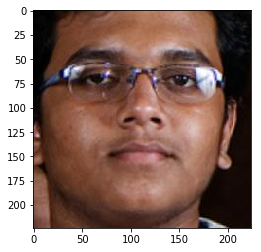

----------------------
235
Actual:  Latino_Hispanic
Predicted:  Asian


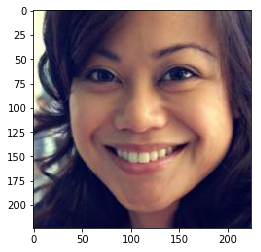

----------------------
237
Actual:  Asian
Predicted:  Asian


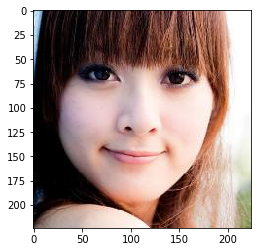

----------------------
339
Actual:  Black
Predicted:  Black


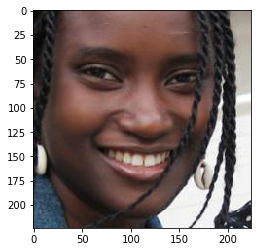

----------------------
375
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


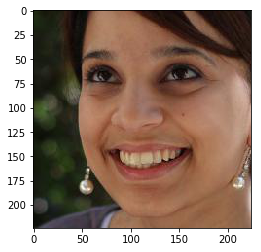

----------------------
413
Actual:  White
Predicted:  White


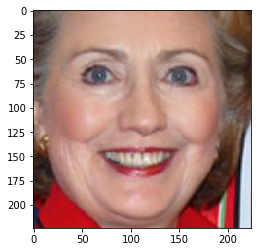

----------------------
447
Actual:  White
Predicted:  White


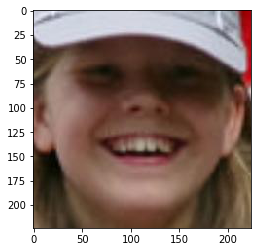

----------------------
470
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


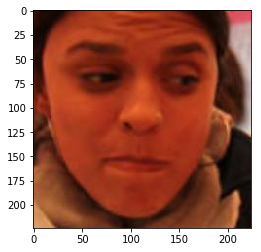

----------------------
573
Actual:  White
Predicted:  White


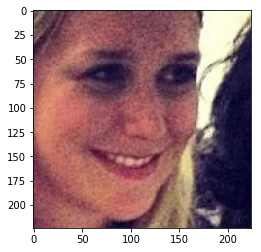

----------------------
609
Actual:  Asian
Predicted:  Asian


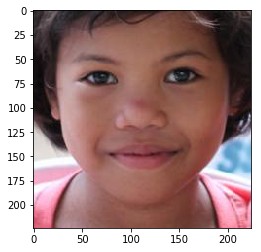

----------------------
638
Actual:  Middle Eastern
Predicted:  Latino_Hispanic


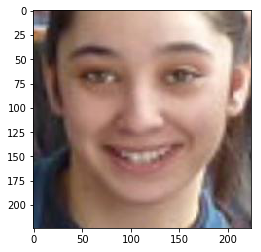

----------------------
649
Actual:  White
Predicted:  White


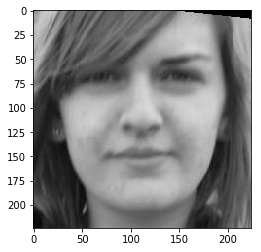

----------------------
718
Actual:  Middle Eastern
Predicted:  Middle Eastern


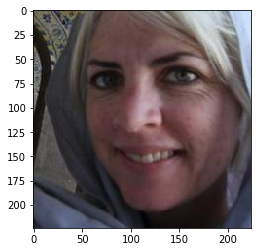

----------------------
723
Actual:  White
Predicted:  Latino_Hispanic


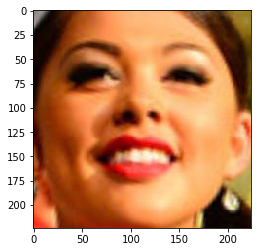

----------------------
750
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


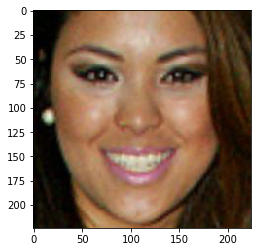

----------------------
758
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


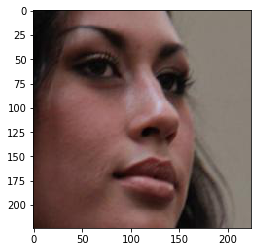

----------------------
762
Actual:  Black
Predicted:  Black


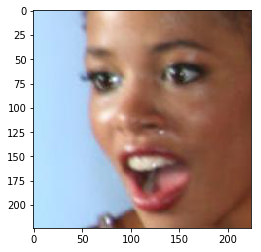

----------------------
817
Actual:  Asian
Predicted:  Asian


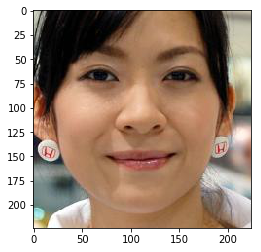

----------------------
875
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


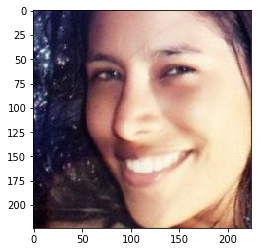

----------------------
899
Actual:  Indian
Predicted:  Indian


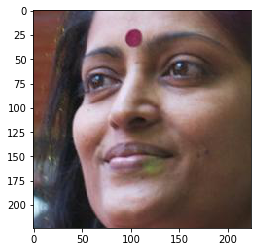

----------------------
913
Actual:  Black
Predicted:  Black


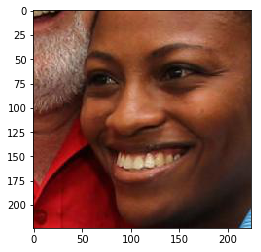

----------------------
992
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


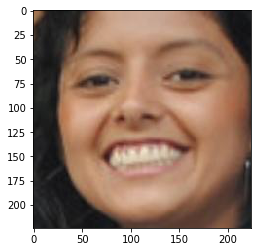

----------------------
1061
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


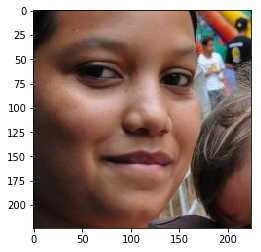

----------------------
1088
Actual:  Middle Eastern
Predicted:  Middle Eastern


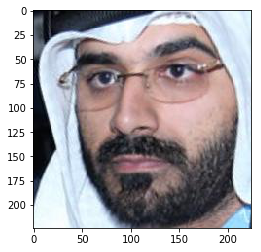

----------------------
1094
Actual:  Indian
Predicted:  Indian


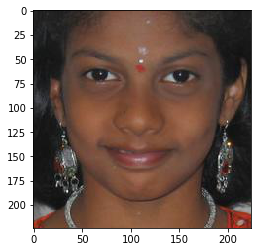

----------------------
1180
Actual:  Indian
Predicted:  Indian


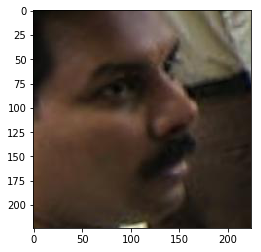

----------------------
1223
Actual:  Asian
Predicted:  Asian


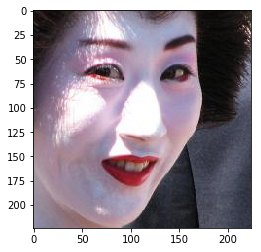

----------------------
1250
Actual:  Indian
Predicted:  Indian


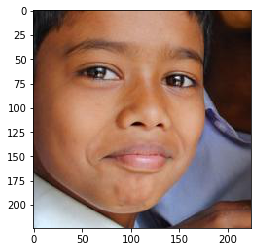

----------------------
1258
Actual:  White
Predicted:  White


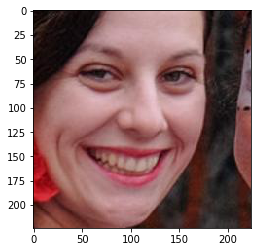

----------------------
1274
Actual:  White
Predicted:  White


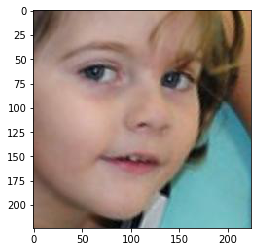

----------------------
1340
Actual:  Black
Predicted:  Black


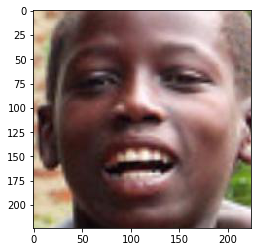

----------------------
1363
Actual:  Black
Predicted:  Black


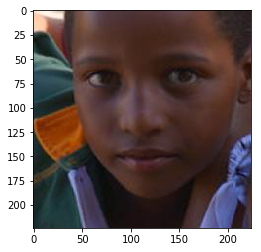

----------------------
1377
Actual:  Asian
Predicted:  Asian


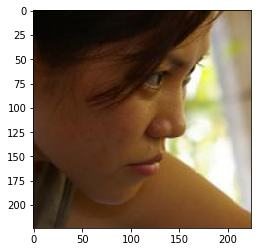

----------------------
1395
Actual:  Indian
Predicted:  Indian


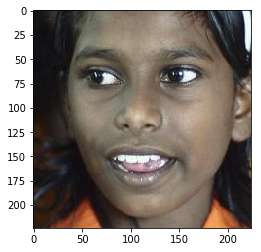

----------------------
1430
Actual:  White
Predicted:  White


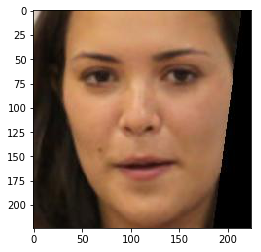

----------------------
1460
Actual:  Middle Eastern
Predicted:  Middle Eastern


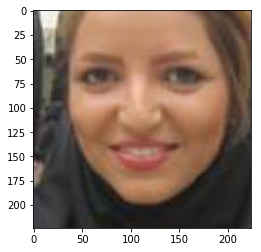

----------------------
1485
Actual:  White
Predicted:  White


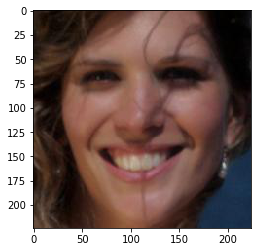

----------------------
1556
Actual:  Indian
Predicted:  Indian


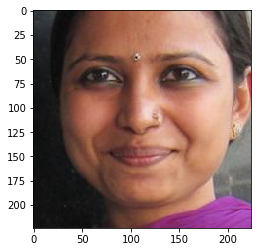

----------------------
2181
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


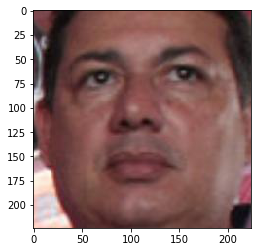

----------------------
2205
Actual:  Black
Predicted:  Black


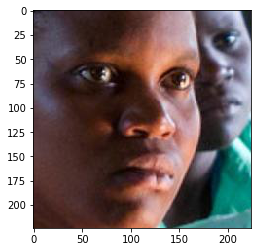

----------------------
2255
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


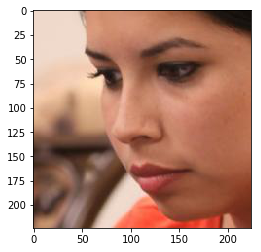

----------------------
4396
Actual:  Middle Eastern
Predicted:  Middle Eastern


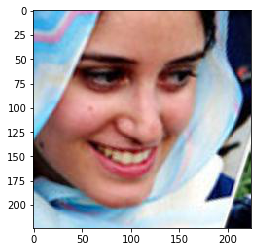

----------------------
4477
Actual:  Middle Eastern
Predicted:  White


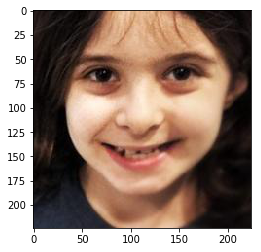

----------------------
4725
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


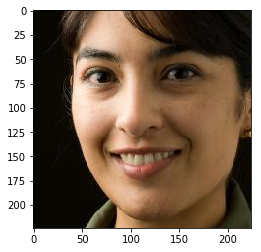

----------------------
4944
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


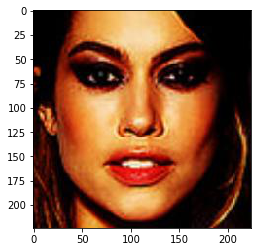

----------------------


In [43]:
prediction_classes = []; actual_classes = []

for i in range(0, predictions.shape[0]):
    prediction = np.argmax(predictions[i])
    prediction_classes.append(races[prediction])
    actual = np.argmax(test_target.values[i])
    actual_classes.append(races[actual])
    
    if i in [
        375, 470, 750, 758, 875, 992, 1061, 2181, 2255, 4725, 4944 #latino
        , 124, 339, 762, 913, 1340, 1363, 2205 #black
        , 33, 83, 237, 609, 817, 1223, 1377 #asian
        , 109, 203, 899, 1094, 1180, 1250, 1395, 1556 #indian
        , 638, 718, 1088, 1460, 4396, 4477 #middle eastern
        , 413, 447, 573, 649, 723, 1258, 1274, 1430, 1485 #white
        , 17, 235, #misclassified
    ]:
        print(i)
        print("Actual: ",races[actual])
        print("Predicted: ",races[prediction])
        
        img = (test_df.iloc[i]['pixels'].reshape([224, 224, 3])) / 255
        plt.imshow(img)
        plt.show()
        print("----------------------")

# Confusion Matrix

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [47]:
cm = confusion_matrix(actual_classes, prediction_classes)

In [48]:
cm

array([[2683,   63,   39,   81,   10,   89],
       [ 116, 1209,   74,  112,    8,   37],
       [ 151,   93,  817,  285,   88,   82],
       [ 237,   74,  111,  735,  136,  330],
       [  45,   17,   71,  241,  500,  335],
       [ 140,   20,   17,  232,  152, 1524]])

In [49]:
df_cm = pd.DataFrame(cm, index=races, columns=races)

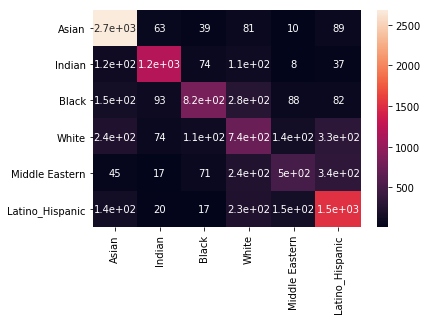

In [50]:
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})

# Predictions for images out of the data set

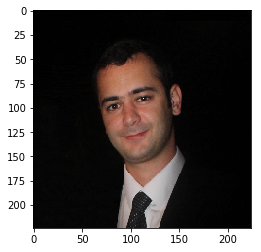

Prediction:  White
---------------------------


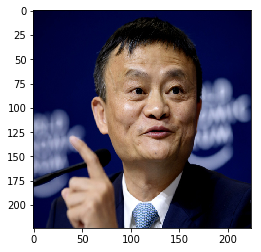

Prediction:  Asian
---------------------------


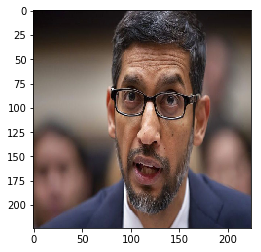

Prediction:  Middle Eastern
---------------------------


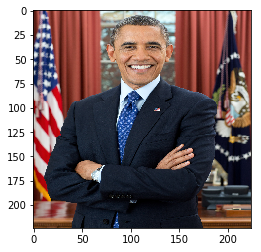

Prediction:  Black
---------------------------


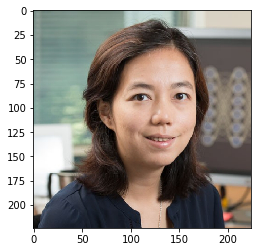

Prediction:  Asian
---------------------------


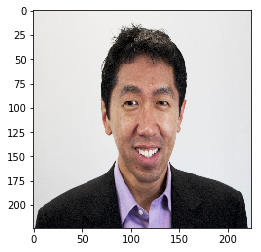

Prediction:  Asian
---------------------------


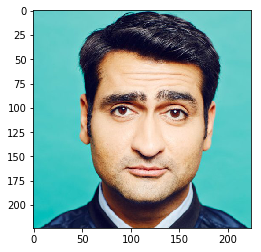

Prediction:  Middle Eastern
---------------------------


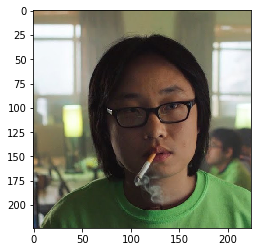

Prediction:  Middle Eastern
---------------------------


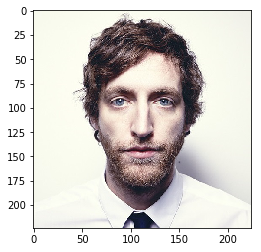

Prediction:  White
---------------------------


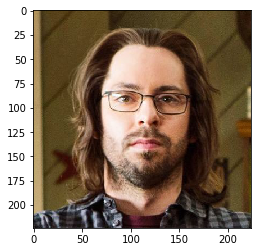

Prediction:  Middle Eastern
---------------------------


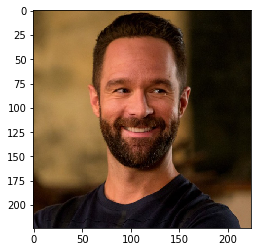

Prediction:  Latino_Hispanic
---------------------------


In [58]:
demo_set = ['sefiks4.jpg'
            , 'jackma.jpg', 'sundar-pichai.jpg'
            , 'obama.jpg'
            , 'fei-fei-li.jpg', 'andrew.jpg'
            , 'dinesh.jpg', 'jian-yang.jpg', 'richard-hendricks.jpg', 'gilfoyle.jpg', 'russ-hanneman.jpg']

for file in demo_set:
    path = 'demo/%s' % (file) 
    img = image.load_img(path, grayscale=False, target_size=target_size)
    img = image.img_to_array(img).reshape(1, -1)[0]
    img = img.reshape(224, 224, 3)
    img = img / 255
    
    plt.imshow(img)
    plt.show()
    
    img = np.expand_dims(img, axis=0) 

    prediction_proba = race_model.predict(img)

    print("Prediction: ",races[np.argmax(prediction_proba)])
    print("---------------------------")